In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'absolute'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6814078441480311 	 Validation loss: 0.6827465204869286 	 
  1%|          | 574/57400 [00:05<08:22, 113.00it/s]
Epoch 2 	 Training loss: 0.6742919432161577 	 Validation loss: 0.6696970957820698 	 
  2%|▏         | 1148/57400 [00:11<08:26, 111.09it/s]
Epoch 3 	 Training loss: 0.662530037688046 	 Validation loss: 0.6597980816485518 	 
  3%|▎         | 1722/57400 [00:16<08:08, 114.02it/s]
Epoch 4 	 Training loss: 0.6540358453885188 	 Validation loss: 0.6552607326184289 	 
  4%|▍         | 2296/57400 [00:22<08:14, 111.48it/s]
Epoch 5 	 Training loss: 0.64601418999014 	 Validation loss: 0.645994997630685 	 
  5%|▌         | 2870/57400 [00:27<08:03, 112.67it/s]
Epoch 6 	 Training loss: 0.6359237883149124 	 Validation loss: 0.6370938278860965 	 
  6%|▌         | 3444/57400 [00:33<08:01, 112.06it/s]
Epoch 7 	 Training loss: 0.6255648923252518 	 Validation loss: 0.6275682035139052 	 
  7%|▋         | 4018/57400 [00:38<07:49, 113.76it/s]
Epoch 8 	 Training loss: 0.61520

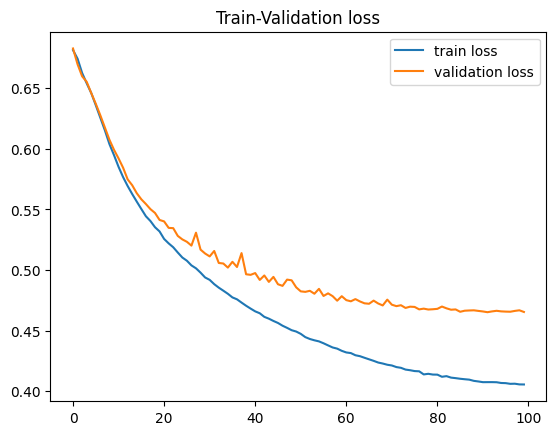

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7334183673469388, 'precision': 0.7334183673469388, 'f1': 0.7334183673469389, 'accuracy': 0.7334183673469388}
MALE {'recall': 0.7942708333333334, 'precision': 0.7942708333333334, 'f1': 0.7942708333333333, 'accuracy': 0.7942708333333334}
FEMALE {'recall': 0.675, 'precision': 0.675, 'f1': 0.675, 'accuracy': 0.675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5757575757575758, 'precision': 0.5757575757575758, 'f1': 0.5757575757575758, 'accuracy': 0.5757575757575758}
MALE {'recall': 0.6253041362530414, 'precision': 0.6253041362530414, 'f1': 0.6253041362530414, 'accuracy': 0.6253041362530414}
FEMALE {'recall': 0.5223097112860893, 'precision': 0.5223097112860893, 'f1': 0.5223097112860893, 'accuracy': 0.5223097112860893} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5853976531942634, 'precision': 0.5853976531942634, 'f1': 0.5853976531942634, 'accuracy': 0.5853976531942634}
MALE {'recall': 0.58

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6804275643534776 	 Validation loss: 0.6794749164985399 	 
  1%|          | 574/57400 [00:05<08:27, 111.93it/s]
Epoch 2 	 Training loss: 0.6711784899234772 	 Validation loss: 0.6639022423049151 	 
  2%|▏         | 1148/57400 [00:11<08:40, 108.06it/s]
Epoch 3 	 Training loss: 0.6579043293040804 	 Validation loss: 0.6500473224510581 	 
  3%|▎         | 1722/57400 [00:16<08:16, 112.16it/s]
Epoch 4 	 Training loss: 0.6483084230265136 	 Validation loss: 0.6404733294147557 	 
  4%|▍         | 2296/57400 [00:22<08:17, 110.69it/s]
Epoch 5 	 Training loss: 0.6418037478932105 	 Validation loss: 0.6354343911348763 	 
  5%|▌         | 2870/57400 [00:27<08:08, 111.69it/s]
Epoch 6 	 Training loss: 0.6349548214611691 	 Validation loss: 0.6289809315891589 	 
  6%|▌         | 3444/57400 [00:33<08:05, 111.22it/s]
Epoch 7 	 Training loss: 0.6290682846037768 	 Validation loss: 0.6224998356932301 	 
  7%|▋         | 4018/57400 [00:39<07:57, 111.86it/s]
Epoch 8 	 Training loss: 0.6

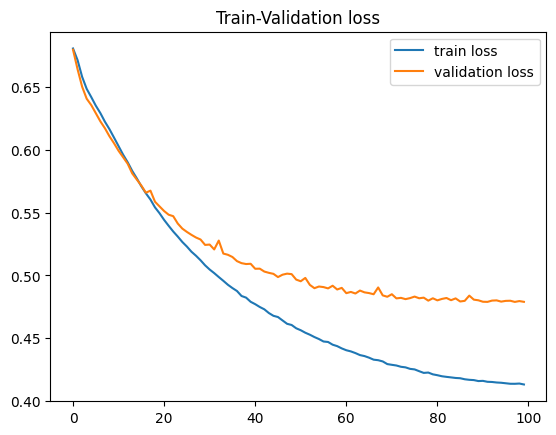

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7168367346938775, 'precision': 0.7168367346938775, 'f1': 0.7168367346938774, 'accuracy': 0.7168367346938775}
MALE {'recall': 0.8177083333333334, 'precision': 0.8177083333333334, 'f1': 0.8177083333333333, 'accuracy': 0.8177083333333334}
FEMALE {'recall': 0.62, 'precision': 0.62, 'f1': 0.62, 'accuracy': 0.62} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5934343434343434, 'precision': 0.5934343434343434, 'f1': 0.5934343434343434, 'accuracy': 0.5934343434343434}
MALE {'recall': 0.6690997566909975, 'precision': 0.6690997566909975, 'f1': 0.6690997566909975, 'accuracy': 0.6690997566909975}
FEMALE {'recall': 0.5118110236220472, 'precision': 0.5118110236220472, 'f1': 0.5118110236220472, 'accuracy': 0.5118110236220472} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5958279009126467, 'precision': 0.5958279009126467, 'f1': 0.5958279009126467, 'accuracy': 0.5958279009126467}
MALE {'recall': 0.659090

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6798004901575294 	 Validation loss: 0.6767849073571673 	 
  1%|          | 574/57400 [00:05<08:28, 111.82it/s]
Epoch 2 	 Training loss: 0.6624246611412394 	 Validation loss: 0.6617650086596861 	 
  2%|▏         | 1148/57400 [00:11<08:22, 111.96it/s]
Epoch 3 	 Training loss: 0.6516372567685224 	 Validation loss: 0.6534639687861427 	 
  3%|▎         | 1722/57400 [00:16<08:36, 107.80it/s]
Epoch 4 	 Training loss: 0.6435174776909659 	 Validation loss: 0.6481842873460155 	 
  4%|▍         | 2296/57400 [00:22<08:23, 109.43it/s]
Epoch 5 	 Training loss: 0.635437397175965 	 Validation loss: 0.6410488213522959 	 
  5%|▌         | 2870/57400 [00:27<08:09, 111.33it/s]
Epoch 6 	 Training loss: 0.6283937401887847 	 Validation loss: 0.6343347157462168 	 
  6%|▌         | 3444/57400 [00:33<08:03, 111.60it/s]
Epoch 7 	 Training loss: 0.6209484869387092 	 Validation loss: 0.6299616179223788 	 
  7%|▋         | 4018/57400 [00:38<07:53, 112.63it/s]
Epoch 8 	 Training loss: 0.61

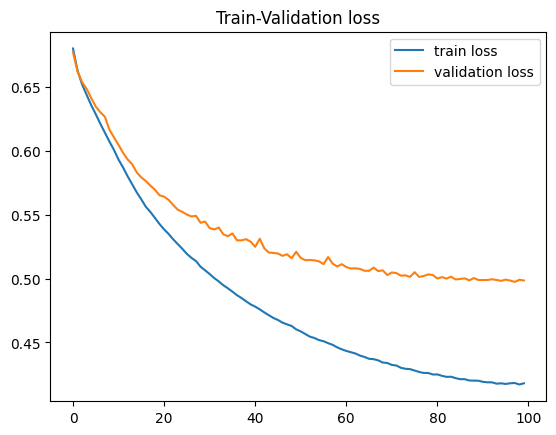

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6964285714285714, 'precision': 0.6964285714285714, 'f1': 0.6964285714285714, 'accuracy': 0.6964285714285714}
MALE {'recall': 0.7864583333333334, 'precision': 0.7864583333333334, 'f1': 0.7864583333333334, 'accuracy': 0.7864583333333334}
FEMALE {'recall': 0.61, 'precision': 0.61, 'f1': 0.61, 'accuracy': 0.61} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5997474747474747, 'precision': 0.5997474747474747, 'f1': 0.5997474747474747, 'accuracy': 0.5997474747474747}
MALE {'recall': 0.7007299270072993, 'precision': 0.7007299270072993, 'f1': 0.7007299270072993, 'accuracy': 0.7007299270072993}
FEMALE {'recall': 0.49081364829396323, 'precision': 0.49081364829396323, 'f1': 0.49081364829396323, 'accuracy': 0.49081364829396323} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5893089960886571, 'precision': 0.5893089960886571, 'f1': 0.5893089960886571, 'accuracy': 0.5893089960886571}
MALE {'recall': 0.61

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7155612244897959, 'precision': 0.7155612244897959, 'f1': 0.7155612244897959, 'accuracy': 0.7155612244897959}
Métricas etiqueta male: {'recall': 0.7994791666666667, 'precision': 0.7994791666666667, 'f1': 0.7994791666666666, 'accuracy': 0.7994791666666667}
Métricas etiqueta female:  {'recall': 0.635, 'precision': 0.635, 'f1': 0.635, 'accuracy': 0.635}

 to
Resultado global: {'recall': 0.5896464646464646, 'precision': 0.5896464646464646, 'f1': 0.5896464646464646, 'accuracy': 0.5896464646464646}
Métricas etiqueta male: {'recall': 0.6650446066504461, 'precision': 0.6650446066504461, 'f1': 0.6650446066504461, 'accuracy': 0.6650446066504461}
Métricas etiqueta female:  {'recall': 0.5083114610673666, 'precision': 0.5083114610673666, 'f1': 0.5083114610673666, 'accuracy': 0.5083114610673666}

 as
Resultado global: {'recall': 0.5901781833985223, 'precision': 0.5901781833985223, 'f1': 0.5901781833985223, 'accuracy': 0.5901781833985223}
Mét

## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932242748421659 	 Validation loss: 0.6925930744510586 	 
  1%|          | 574/57400 [00:06<09:34, 98.99it/s]
Epoch 2 	 Training loss: 0.6932029362754955 	 Validation loss: 0.69257734892732 	 
  2%|▏         | 1148/57400 [00:12<09:28, 98.99it/s]
Epoch 3 	 Training loss: 0.6930913382083281 	 Validation loss: 0.6929502305337938 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:28, 97.99it/s]
Epoch 4 	 Training loss: 0.6931219262943866 	 Validation loss: 0.6930870979519214 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:28, 97.00it/s]
Epoch 5 	 Training loss: 0.6931370778158567 	 Validation loss: 0.6924880490464679 	 
  5%|▌         | 2870/57400 [00:31<09:08, 99.38it/s]
Epoch 6 	 Training loss: 0.6931661240730551 	 Validation loss: 0.692771012500181 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:01, 99.71it/s]
Epoch 7 	 Training loss: 0.6931748201207417 	 Validation loss: 0.6927538695981947 	 

2 e

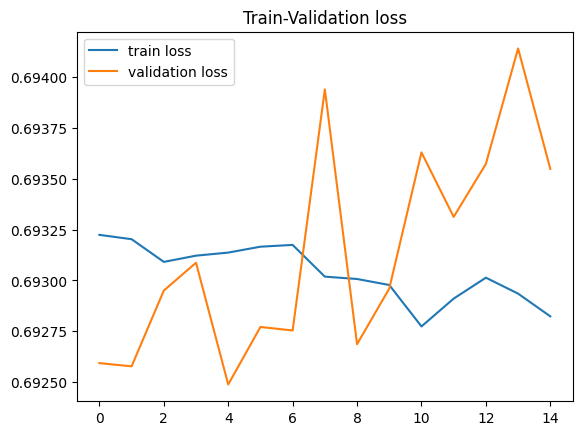

In [23]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4961734693877551, 'precision': 0.4961734693877551, 'f1': 0.4961734693877551, 'accuracy': 0.4961734693877551}
MALE {'recall': 0.0703125, 'precision': 0.0703125, 'f1': 0.0703125, 'accuracy': 0.0703125}
FEMALE {'recall': 0.905, 'precision': 0.905, 'f1': 0.905, 'accuracy': 0.905} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.05596107055961071, 'precision': 0.05596107055961071, 'f1': 0.05596107055961071, 'accuracy': 0.05596107055961071}
FEMALE {'recall': 0.9291338582677166, 'precision': 0.9291338582677166, 'f1': 0.9291338582677164, 'accuracy': 0.9291338582677166} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4771838331160365, 'precision': 0.4771838331160365, 'f1': 0.4771838331160365, 'accuracy': 0.4771838331160365}
MALE {'recall': 0.050505050505050504, 'precision': 0.050

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933121465224422 	 Validation loss: 0.6935206934557123 	 
  1%|          | 574/57400 [00:06<09:40, 97.89it/s]
Epoch 2 	 Training loss: 0.693195946332885 	 Validation loss: 0.6928944173505751 	 
  2%|▏         | 1148/57400 [00:12<09:24, 99.70it/s]
Epoch 3 	 Training loss: 0.6930802004470227 	 Validation loss: 0.6933507151522879 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:21, 99.11it/s]
Epoch 4 	 Training loss: 0.6931445648445901 	 Validation loss: 0.6938675328836603 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:08, 100.45it/s]
Epoch 5 	 Training loss: 0.6930621720149542 	 Validation loss: 0.6941914699845395 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:12, 98.78it/s]
Epoch 6 	 Training loss: 0.6930544795890303 	 Validation loss: 0.6930590332564661 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:04, 99.10it/s]
Epoch 7 	 Training loss: 0.6930077488206405 	 Validation 

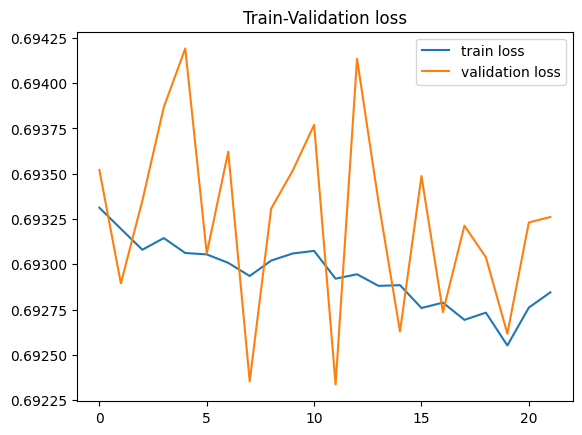

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.3567708333333333, 'precision': 0.3567708333333333, 'f1': 0.3567708333333333, 'accuracy': 0.3567708333333333}
FEMALE {'recall': 0.655, 'precision': 0.655, 'f1': 0.655, 'accuracy': 0.655} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5113636363636364, 'precision': 0.5113636363636364, 'f1': 0.5113636363636364, 'accuracy': 0.5113636363636364}
MALE {'recall': 0.340632603406326, 'precision': 0.340632603406326, 'f1': 0.340632603406326, 'accuracy': 0.340632603406326}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4784876140808344, 'precision': 0.4784876140808344, 'f1': 0.4784876140808344, 'accuracy': 0.4784876140808344}
MALE {'recall': 0.305555

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932349894520298 	 Validation loss: 0.6918774307784388 	 
  1%|          | 574/57400 [00:06<09:52, 95.91it/s]
Epoch 2 	 Training loss: 0.6931644873336632 	 Validation loss: 0.6937310645135782 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:28, 98.94it/s]
Epoch 3 	 Training loss: 0.6933001514511241 	 Validation loss: 0.6933871224775152 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:14, 100.38it/s]
Epoch 4 	 Training loss: 0.6931225315826696 	 Validation loss: 0.6930281176405438 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:10, 100.02it/s]
Epoch 5 	 Training loss: 0.6930929822165791 	 Validation loss: 0.6938314548993515 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:07, 99.56it/s]
Epoch 6 	 Training loss: 0.6930652749870713 	 Validation loss: 0.6937208468631163 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:54, 100.92it/s]
Epoch 7 	 Training loss: 

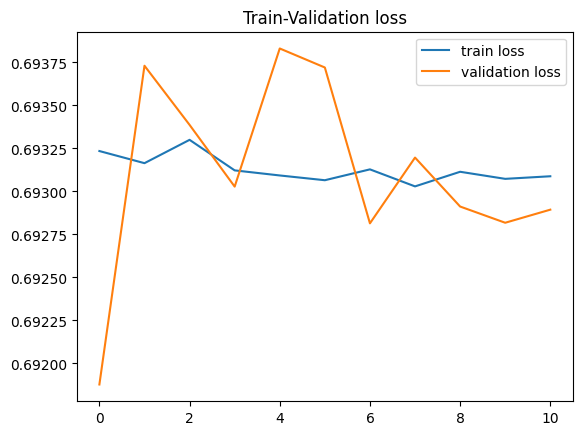

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
Métricas etiqueta male: {'recall': 0.1423611111111111, 'precision': 0.1423611111111111, 'f1': 0.1423611111111111, 'accuracy': 0.1423611111111111}
Métricas etiqueta female:  {'recall': 0.8533333333333334, 'precision': 0.8533333333333334, 'f1': 0.8533333333333334, 'accuracy': 0.8533333333333334}

 to
Resultado global: {'recall': 0.48947811447811446, 'precision': 0.48947811447811446, 'f1': 0.48947811447811446, 'accuracy': 0.48947811447811446}
Métricas etiqueta male: {'recall': 0.1321978913219789, 'precision': 0.1321978913219789, 'f1': 0.1321978913219789, 'accuracy': 0.1321978913219789}
Métricas etiqueta female:  {'recall': 0.8748906386701663, 'precision': 0.8748906386701663, 'f1': 0.8748906386701661, 'accuracy': 0.8748906386701663}

 as
Resultado global: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1

# AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932535205776268 	 Validation loss: 0.6926488926855184 	 
  1%|          | 574/57400 [00:06<09:36, 98.63it/s]
Epoch 2 	 Training loss: 0.6932220197305446 	 Validation loss: 0.6939326645964283 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:38, 97.16it/s]
Epoch 3 	 Training loss: 0.693174901428123 	 Validation loss: 0.6920963919768899 	 
  3%|▎         | 1722/57400 [00:18<09:32, 97.24it/s]
Epoch 4 	 Training loss: 0.6930721018995557 	 Validation loss: 0.6936478544089754 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:35, 95.69it/s]
Epoch 5 	 Training loss: 0.6931718993893068 	 Validation loss: 0.6931862477528847 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:15, 98.14it/s]
Epoch 6 	 Training loss: 0.6931949979544517 	 Validation loss: 0.6933977472580085 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:07, 98.49it/s]
Epoch 7 	 Training loss: 0.693008550783483 	 Validation lo

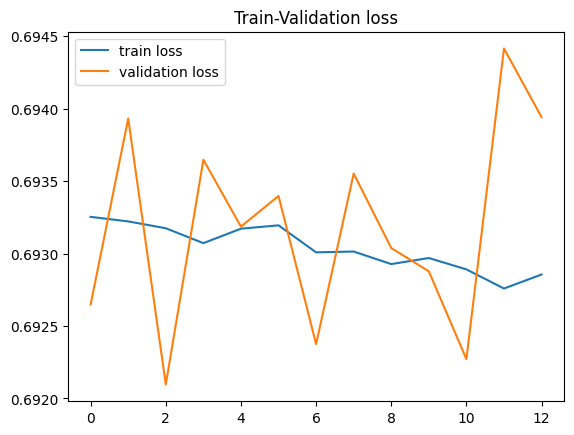

In [31]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 0.018229166666666668, 'precision': 0.018229166666666668, 'f1': 0.018229166666666668, 'accuracy': 0.018229166666666668}
FEMALE {'recall': 0.9425, 'precision': 0.9425, 'f1': 0.9425, 'accuracy': 0.9425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
MALE {'recall': 0.031630170316301706, 'precision': 0.031630170316301706, 'f1': 0.031630170316301706, 'accuracy': 0.031630170316301706}
FEMALE {'recall': 0.9606299212598425, 'precision': 0.9606299212598425, 'f1': 0.9606299212598425, 'accuracy': 0.9606299212598425} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932600926646788 	 Validation loss: 0.69197580571902 	 
  1%|          | 574/57400 [00:06<09:53, 95.69it/s]
Epoch 2 	 Training loss: 0.6932938655494397 	 Validation loss: 0.6929780416569468 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:30, 98.66it/s]
Epoch 3 	 Training loss: 0.6931751852251511 	 Validation loss: 0.6933514485924931 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:32, 97.30it/s]
Epoch 4 	 Training loss: 0.6931841933145756 	 Validation loss: 0.692693633548284 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:26, 97.31it/s]
Epoch 5 	 Training loss: 0.6931774976569186 	 Validation loss: 0.693815281835653 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:14, 98.39it/s]
Epoch 6 	 Training loss: 0.6930529102423465 	 Validation loss: 0.6926228464659998 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:58, 100.28it/s]
Epoch 7 	 Training loss: 0.6930

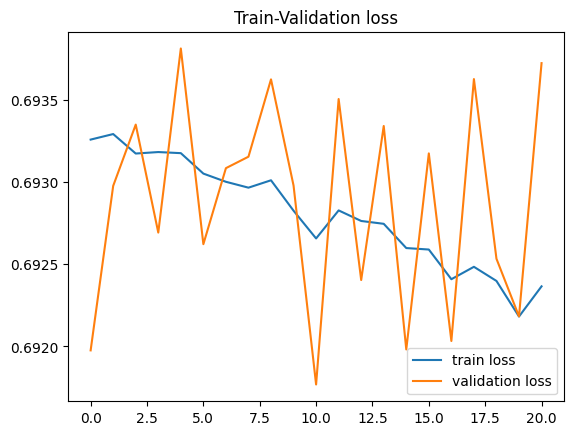

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49744897959183676, 'precision': 0.49744897959183676, 'f1': 0.49744897959183676, 'accuracy': 0.49744897959183676}
MALE {'recall': 0.4296875, 'precision': 0.4296875, 'f1': 0.4296875, 'accuracy': 0.4296875}
FEMALE {'recall': 0.5625, 'precision': 0.5625, 'f1': 0.5625, 'accuracy': 0.5625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.39416058394160586, 'precision': 0.39416058394160586, 'f1': 0.3941605839416059, 'accuracy': 0.39416058394160586}
FEMALE {'recall': 0.5774278215223098, 'precision': 0.5774278215223098, 'f1': 0.5774278215223098, 'accuracy': 0.5774278215223098} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276401564}
MALE {'recall': 0.4393939393939394, 'prec

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933569733689471 	 Validation loss: 0.6937382089889655 	 
  1%|          | 574/57400 [00:06<09:36, 98.57it/s]
Epoch 2 	 Training loss: 0.6932765514385409 	 Validation loss: 0.6928340762348498 	 
  2%|▏         | 1148/57400 [00:12<09:30, 98.65it/s]
Epoch 3 	 Training loss: 0.6932607085447278 	 Validation loss: 0.6936719892388683 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:20, 99.32it/s]
Epoch 4 	 Training loss: 0.6931083455733721 	 Validation loss: 0.692952200517816 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:08, 100.38it/s]
Epoch 5 	 Training loss: 0.6930446673561056 	 Validation loss: 0.6933949357372219 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:30, 95.64it/s]
Epoch 6 	 Training loss: 0.6930087608535115 	 Validation loss: 0.6932413093114304 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:22, 95.97it/s]
Epoch 7 	 Training loss: 0.6929639816699543 	 Validation 

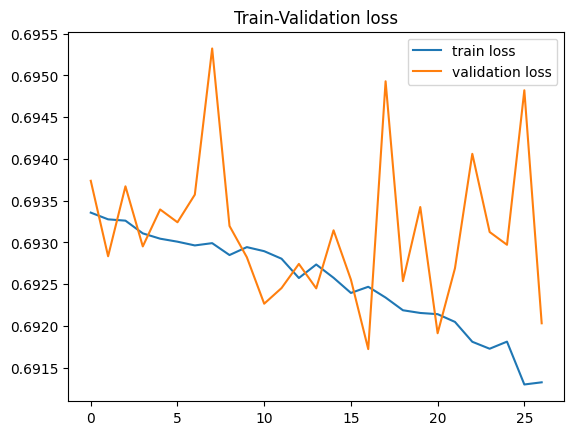

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.45535714285714285, 'precision': 0.45535714285714285, 'f1': 0.45535714285714285, 'accuracy': 0.45535714285714285}
MALE {'recall': 0.22135416666666666, 'precision': 0.22135416666666666, 'f1': 0.22135416666666666, 'accuracy': 0.22135416666666666}
FEMALE {'recall': 0.68, 'precision': 0.68, 'f1': 0.68, 'accuracy': 0.68} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.2846715328467153, 'precision': 0.2846715328467153, 'f1': 0.2846715328467153, 'accuracy': 0.2846715328467153}
FEMALE {'recall': 0.7322834645669292, 'precision': 0.7322834645669292, 'f1': 0.732283464566929, 'accuracy': 0.7322834645669292} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5123859191655802, 'precision': 0.5123859191655802, 'f1': 0.5123859191655802, 'accuracy': 0.5123859191655802}
MALE {'recall': 0.25757575757575757, 'precision': 0.25757575757575757, 'f1': 

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.48086734693877553, 'precision': 0.48086734693877553, 'f1': 0.48086734693877553, 'accuracy': 0.48086734693877553}
Métricas etiqueta male: {'recall': 0.22309027777777776, 'precision': 0.22309027777777776, 'f1': 0.22309027777777776, 'accuracy': 0.22309027777777776}
Métricas etiqueta female:  {'recall': 0.7283333333333334, 'precision': 0.7283333333333334, 'f1': 0.7283333333333334, 'accuracy': 0.7283333333333334}

 to
Resultado global: {'recall': 0.48695286195286197, 'precision': 0.48695286195286197, 'f1': 0.48695286195286197, 'accuracy': 0.48695286195286197}
Métricas etiqueta male: {'recall': 0.23682076236820762, 'precision': 0.23682076236820762, 'f1': 0.23682076236820765, 'accuracy': 0.23682076236820762}
Métricas etiqueta female:  {'recall': 0.7567804024496938, 'precision': 0.7567804024496938, 'f1': 0.7567804024496938, 'accuracy': 0.7567804024496938}

 as
Resultado global: {'recall': 0.49760973489787047, 'precision': 0.4976097348

# Pruebas hiperparámetros 2

In [38]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 64

## ABOUT

In [39]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6818071867530769 	 Validation loss: 0.682983179213637 	 
  1%|          | 574/57400 [00:04<06:41, 141.43it/s]
Epoch 2 	 Training loss: 0.6773821938951672 	 Validation loss: 0.6756444391557725 	 
  2%|▏         | 1148/57400 [00:08<06:29, 144.39it/s]
Epoch 3 	 Training loss: 0.6621046125473461 	 Validation loss: 0.6604504261986684 	 
  3%|▎         | 1722/57400 [00:12<06:33, 141.54it/s]
Epoch 4 	 Training loss: 0.6500096608745096 	 Validation loss: 0.6505820417808275 	 
  4%|▍         | 2296/57400 [00:17<06:24, 143.38it/s]
Epoch 5 	 Training loss: 0.6414833619204132 	 Validation loss: 0.6440923496828241 	 
  5%|▌         | 2870/57400 [00:21<06:19, 143.74it/s]
Epoch 6 	 Training loss: 0.6344447871118473 	 Validation loss: 0.6381976321592169 	 
  6%|▌         | 3444/57400 [00:25<06:15, 143.71it/s]
Epoch 7 	 Training loss: 0.6279476435549999 	 Validation loss: 0.6343309778278157 	 
  7%|▋         | 4018/57400 [00:30<06:21, 139.99it/s]
Epoch 8 	 Training loss: 0.62

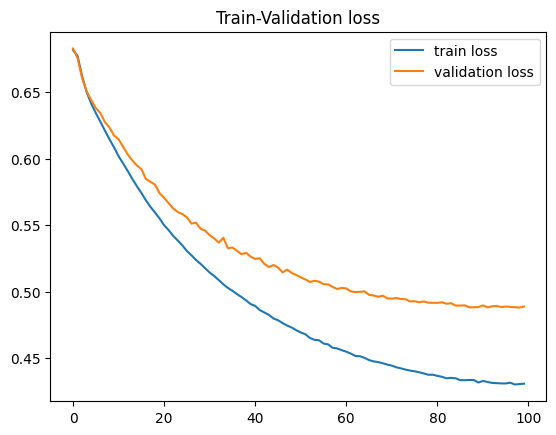

In [40]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [41]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7104591836734694, 'precision': 0.7104591836734694, 'f1': 0.7104591836734694, 'accuracy': 0.7104591836734694}
MALE {'recall': 0.7708333333333334, 'precision': 0.7708333333333334, 'f1': 0.7708333333333333, 'accuracy': 0.7708333333333334}
FEMALE {'recall': 0.6525, 'precision': 0.6525, 'f1': 0.6525, 'accuracy': 0.6525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5845959595959596, 'precision': 0.5845959595959596, 'f1': 0.5845959595959596, 'accuracy': 0.5845959595959596}
MALE {'recall': 0.6496350364963503, 'precision': 0.6496350364963503, 'f1': 0.6496350364963503, 'accuracy': 0.6496350364963503}
FEMALE {'recall': 0.5144356955380578, 'precision': 0.5144356955380578, 'f1': 0.5144356955380578, 'accuracy': 0.5144356955380578} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6140808344198174, 'precision': 0.6140808344198174, 'f1': 0.6140808344198174, 'accuracy': 0.6140808344198174}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6810250654037822 	 Validation loss: 0.6826662380816573 	 
  1%|          | 574/57400 [00:04<06:37, 143.10it/s]
Epoch 2 	 Training loss: 0.6756644803472512 	 Validation loss: 0.6721565622394368 	 
  2%|▏         | 1148/57400 [00:08<06:32, 143.18it/s]
Epoch 3 	 Training loss: 0.6586076353485161 	 Validation loss: 0.6564075340658931 	 
  3%|▎         | 1722/57400 [00:12<06:30, 142.66it/s]
Epoch 4 	 Training loss: 0.64716937016527 	 Validation loss: 0.6483973274796696 	 
  4%|▍         | 2296/57400 [00:17<06:26, 142.51it/s]
Epoch 5 	 Training loss: 0.6377536220417621 	 Validation loss: 0.6420720977298284 	 
  5%|▌         | 2870/57400 [00:21<06:18, 144.03it/s]
Epoch 6 	 Training loss: 0.6296212553770285 	 Validation loss: 0.6351589075589584 	 
  6%|▌         | 3444/57400 [00:25<06:24, 140.17it/s]
Epoch 7 	 Training loss: 0.6217431301439266 	 Validation loss: 0.6285841788275767 	 
  7%|▋         | 4018/57400 [00:30<06:24, 138.90it/s]
Epoch 8 	 Training loss: 0.613

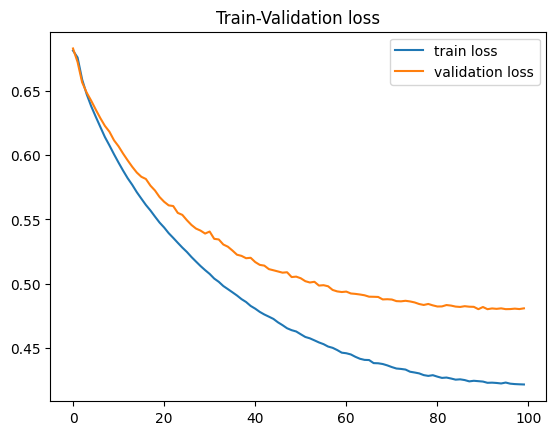

In [42]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [43]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7168367346938775, 'precision': 0.7168367346938775, 'f1': 0.7168367346938774, 'accuracy': 0.7168367346938775}
MALE {'recall': 0.7942708333333334, 'precision': 0.7942708333333334, 'f1': 0.7942708333333333, 'accuracy': 0.7942708333333334}
FEMALE {'recall': 0.6425, 'precision': 0.6425, 'f1': 0.6425, 'accuracy': 0.6425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5593434343434344, 'precision': 0.5593434343434344, 'f1': 0.5593434343434344, 'accuracy': 0.5593434343434344}
MALE {'recall': 0.6399026763990268, 'precision': 0.6399026763990268, 'f1': 0.6399026763990268, 'accuracy': 0.6399026763990268}
FEMALE {'recall': 0.47244094488188976, 'precision': 0.47244094488188976, 'f1': 0.47244094488188976, 'accuracy': 0.47244094488188976} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5867014341590613, 'precision': 0.5867014341590613, 'f1': 0.5867014341590613, 'accuracy': 0.5867014341590613}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6809295487528478 	 Validation loss: 0.6799071239212812 	 
  1%|          | 574/57400 [00:04<06:37, 143.06it/s]
Epoch 2 	 Training loss: 0.668866822424666 	 Validation loss: 0.6619861742197457 	 
  2%|▏         | 1148/57400 [00:08<06:34, 142.49it/s]
Epoch 3 	 Training loss: 0.6564772130097246 	 Validation loss: 0.655787580094095 	 
  3%|▎         | 1722/57400 [00:12<06:34, 141.06it/s]
Epoch 4 	 Training loss: 0.6493800707187387 	 Validation loss: 0.6488222995046842 	 
  4%|▍         | 2296/57400 [00:17<06:32, 140.47it/s]
Epoch 5 	 Training loss: 0.6421012473438675 	 Validation loss: 0.6412779527195429 	 
  5%|▌         | 2870/57400 [00:21<06:22, 142.63it/s]
Epoch 6 	 Training loss: 0.6354883960107478 	 Validation loss: 0.6379723973193411 	 
  6%|▌         | 3444/57400 [00:26<06:18, 142.59it/s]
Epoch 7 	 Training loss: 0.6280946784526213 	 Validation loss: 0.6296078754683673 	 
  7%|▋         | 4018/57400 [00:30<06:19, 140.64it/s]
Epoch 8 	 Training loss: 0.620

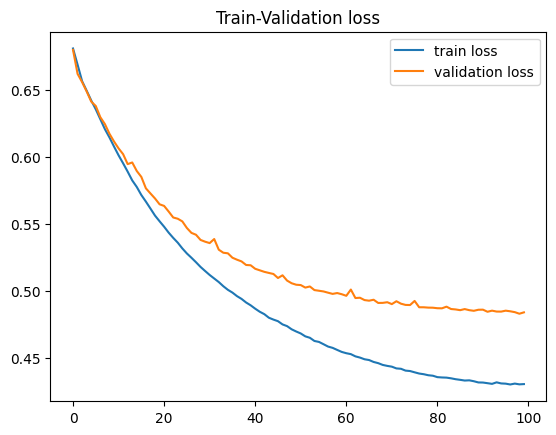

In [44]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [45]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7181122448979592, 'precision': 0.7181122448979592, 'f1': 0.7181122448979592, 'accuracy': 0.7181122448979592}
MALE {'recall': 0.796875, 'precision': 0.796875, 'f1': 0.796875, 'accuracy': 0.796875}
FEMALE {'recall': 0.6425, 'precision': 0.6425, 'f1': 0.6425, 'accuracy': 0.6425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5934343434343434, 'precision': 0.5934343434343434, 'f1': 0.5934343434343434, 'accuracy': 0.5934343434343434}
MALE {'recall': 0.6788321167883211, 'precision': 0.6788321167883211, 'f1': 0.6788321167883211, 'accuracy': 0.6788321167883211}
FEMALE {'recall': 0.5013123359580053, 'precision': 0.5013123359580053, 'f1': 0.5013123359580053, 'accuracy': 0.5013123359580053} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5893089960886571, 'precision': 0.5893089960886571, 'f1': 0.5893089960886571, 'accuracy': 0.5893089960886571}
MALE {'recall': 0.6414141414141414, 'precision': 0.64141

In [46]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7151360544217688, 'precision': 0.7151360544217688, 'f1': 0.7151360544217686, 'accuracy': 0.7151360544217688}
Métricas etiqueta male: {'recall': 0.787326388888889, 'precision': 0.787326388888889, 'f1': 0.7873263888888888, 'accuracy': 0.787326388888889}
Métricas etiqueta female:  {'recall': 0.6458333333333333, 'precision': 0.6458333333333333, 'f1': 0.6458333333333333, 'accuracy': 0.6458333333333333}

 to
Resultado global: {'recall': 0.5791245791245792, 'precision': 0.5791245791245792, 'f1': 0.5791245791245792, 'accuracy': 0.5791245791245792}
Métricas etiqueta male: {'recall': 0.6561232765612327, 'precision': 0.6561232765612327, 'f1': 0.6561232765612327, 'accuracy': 0.6561232765612327}
Métricas etiqueta female:  {'recall': 0.49606299212598426, 'precision': 0.49606299212598426, 'f1': 0.49606299212598426, 'accuracy': 0.49606299212598426}

 as
Resultado global: {'recall': 0.5966970882225119, 'precision': 0.5966970882225119, 'f1': 0.

## TO

In [47]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933859623059994 	 Validation loss: 0.6923165028378114 	 
  1%|          | 574/57400 [00:05<07:54, 119.77it/s]
Epoch 2 	 Training loss: 0.6932864938878847 	 Validation loss: 0.6924788658901796 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:38, 122.63it/s]
Epoch 3 	 Training loss: 0.6932086332957503 	 Validation loss: 0.6946708964089215 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:40, 120.97it/s]
Epoch 4 	 Training loss: 0.6931712753058311 	 Validation loss: 0.6944300340393842 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:29, 122.69it/s]
Epoch 5 	 Training loss: 0.693106515897691 	 Validation loss: 0.6923118819624691 	 
  5%|▌         | 2870/57400 [00:25<07:27, 121.84it/s]
Epoch 6 	 Training loss: 0.6931367416830428 	 Validation loss: 0.6929062322034674 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:23, 121.64it/s]
Epoch 7 	 Training loss: 0.6929812388760703 	 Valida

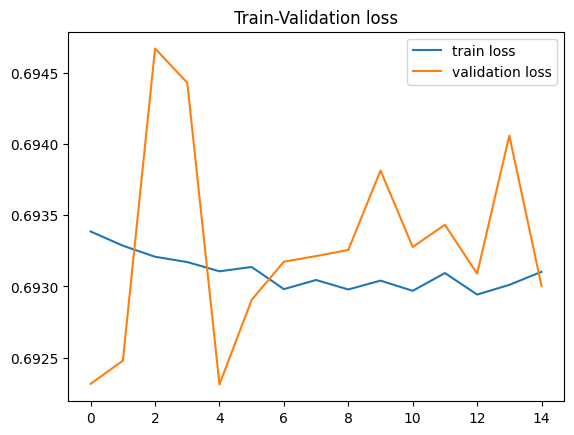

In [48]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [49]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.018229166666666668, 'precision': 0.018229166666666668, 'f1': 0.018229166666666668, 'accuracy': 0.018229166666666668}
FEMALE {'recall': 0.975, 'precision': 0.975, 'f1': 0.975, 'accuracy': 0.975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4696969696969697, 'precision': 0.4696969696969697, 'f1': 0.4696969696969697, 'accuracy': 0.4696969696969697}
MALE {'recall': 0.019464720194647202, 'precision': 0.019464720194647202, 'f1': 0.019464720194647202, 'accuracy': 0.019464720194647202}
FEMALE {'recall': 0.9553805774278216, 'precision': 0.9553805774278216, 'f1': 0.9553805774278216, 'accuracy': 0.9553805774278216} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1': 0.47979139504563234, 'accuracy': 0.47979139504563234}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932804312440161 	 Validation loss: 0.6940065248537872 	 
  1%|          | 574/57400 [00:05<07:43, 122.64it/s]
Epoch 2 	 Training loss: 0.6931800895243987 	 Validation loss: 0.6928080067796222 	 
  2%|▏         | 1148/57400 [00:10<07:47, 120.43it/s]
Epoch 3 	 Training loss: 0.6931947851845611 	 Validation loss: 0.6934981578487461 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:31, 123.36it/s]
Epoch 4 	 Training loss: 0.6931225595158567 	 Validation loss: 0.6936538936728138 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:43, 118.82it/s]
Epoch 5 	 Training loss: 0.6930929143046668 	 Validation loss: 0.6932242381370674 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:25, 122.43it/s]
Epoch 6 	 Training loss: 0.6931275983928388 	 Validation loss: 0.6935915785320734 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:28, 120.35it/s]
Epoch 7 	 Training loss: 0.6929877012033496 	 Valid

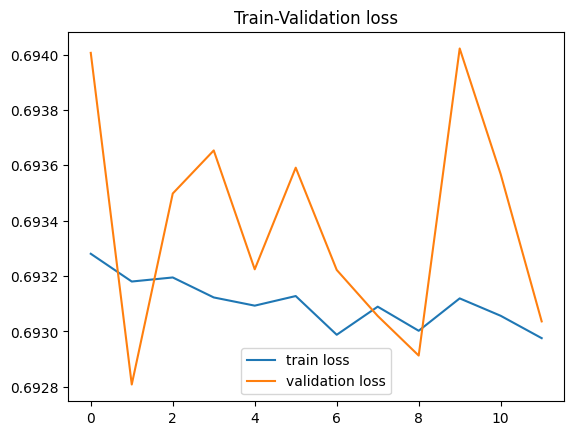

In [50]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [51]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.9868766404199475, 'precision': 0.9868766404199475, 'f1': 0.9868766404199475, 'accuracy': 0.9868766404199475} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}
MALE {'recall': 0.0025252525252525255, 'precision': 0.0025252525252525255, 'f1': 0.0025252525252525255, 'accuracy': 0.0025252525

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933569310018826 	 Validation loss: 0.6927229075108544 	 
  1%|          | 574/57400 [00:05<07:49, 121.13it/s]
Epoch 2 	 Training loss: 0.6932923473962923 	 Validation loss: 0.6944463505583295 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:48, 120.14it/s]
Epoch 3 	 Training loss: 0.6931057286802484 	 Validation loss: 0.6942928483930685 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:37, 121.75it/s]
Epoch 4 	 Training loss: 0.6932026121882197 	 Validation loss: 0.6932024218268313 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:27, 123.18it/s]
Epoch 5 	 Training loss: 0.6931476193230327 	 Validation loss: 0.6932370511151976 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:32, 120.43it/s]
Epoch 6 	 Training loss: 0.6931121836348277 	 Validation loss: 0.6932768043825182 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:22, 121.99it/s]
Epoch 7 	 Training los

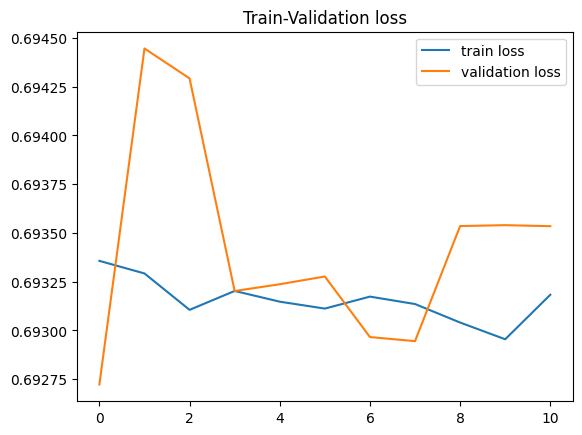

In [52]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [53]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5153061224489796, 'precision': 0.5153061224489796, 'f1': 0.5153061224489796, 'accuracy': 0.5153061224489796}
MALE {'recall': 0.08072916666666667, 'precision': 0.08072916666666667, 'f1': 0.08072916666666667, 'accuracy': 0.08072916666666667}
FEMALE {'recall': 0.9325, 'precision': 0.9325, 'f1': 0.9325, 'accuracy': 0.9325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4696969696969697, 'precision': 0.4696969696969697, 'f1': 0.4696969696969697, 'accuracy': 0.4696969696969697}
MALE {'recall': 0.06569343065693431, 'precision': 0.06569343065693431, 'f1': 0.06569343065693431, 'accuracy': 0.06569343065693431}
FEMALE {'recall': 0.905511811023622, 'precision': 0.905511811023622, 'f1': 0.905511811023622, 'accuracy': 0.905511811023622} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE {'recal

In [54]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5093537414965986, 'precision': 0.5093537414965986, 'f1': 0.5093537414965986, 'accuracy': 0.5093537414965986}
Métricas etiqueta male: {'recall': 0.03298611111111111, 'precision': 0.03298611111111111, 'f1': 0.03298611111111111, 'accuracy': 0.03298611111111111}
Métricas etiqueta female:  {'recall': 0.9666666666666667, 'precision': 0.9666666666666667, 'f1': 0.9666666666666667, 'accuracy': 0.9666666666666667}

 to
Resultado global: {'recall': 0.4713804713804714, 'precision': 0.4713804713804714, 'f1': 0.4713804713804714, 'accuracy': 0.4713804713804714}
Métricas etiqueta male: {'recall': 0.028386050283860504, 'precision': 0.028386050283860504, 'f1': 0.028386050283860504, 'accuracy': 0.028386050283860504}
Métricas etiqueta female:  {'recall': 0.9492563429571304, 'precision': 0.9492563429571304, 'f1': 0.9492563429571304, 'accuracy': 0.9492563429571304}

 as
Resultado global: {'recall': 0.48326814428509346, 'precision': 0.48326814428509

## AS

In [55]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933264937965712 	 Validation loss: 0.6941756100977882 	 
  1%|          | 574/57400 [00:05<07:43, 122.55it/s]
Epoch 2 	 Training loss: 0.6932412389055778 	 Validation loss: 0.6930510421930733 	 
  2%|▏         | 1148/57400 [00:10<07:38, 122.61it/s]
Epoch 3 	 Training loss: 0.6932385356168713 	 Validation loss: 0.6937200730129823 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:42, 120.29it/s]
Epoch 4 	 Training loss: 0.6931840972617943 	 Validation loss: 0.6932512976355472 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:39, 119.82it/s]
Epoch 5 	 Training loss: 0.693003376913403 	 Validation loss: 0.6926307051868762 	 
  5%|▌         | 2870/57400 [00:25<07:26, 122.24it/s]
Epoch 6 	 Training loss: 0.6929668502732852 	 Validation loss: 0.6925290812880306 	 
  6%|▌         | 3444/57400 [00:30<07:20, 122.52it/s]
Epoch 7 	 Training loss: 0.693055459119717 	 Validation loss: 0.6932258939338942 	 

1 epoch without improveme

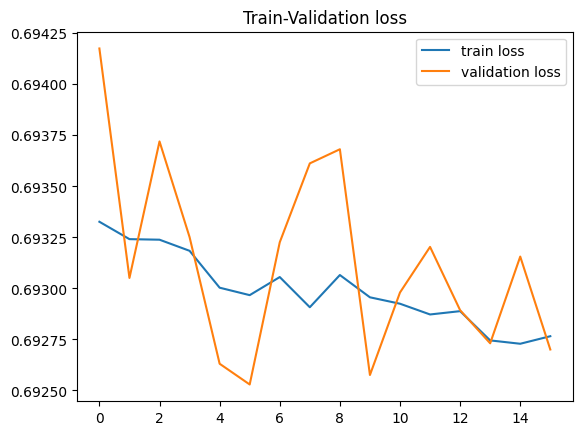

In [56]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [57]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4923469387755102, 'precision': 0.4923469387755102, 'f1': 0.4923469387755102, 'accuracy': 0.4923469387755102}
MALE {'recall': 0.15104166666666666, 'precision': 0.15104166666666666, 'f1': 0.15104166666666666, 'accuracy': 0.15104166666666666}
FEMALE {'recall': 0.82, 'precision': 0.82, 'f1': 0.82, 'accuracy': 0.82} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.1362530413625304, 'precision': 0.1362530413625304, 'f1': 0.1362530413625304, 'accuracy': 0.1362530413625304}
FEMALE {'recall': 0.8713910761154856, 'precision': 0.8713910761154856, 'f1': 0.8713910761154856, 'accuracy': 0.8713910761154856} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5019556714471969, 'precision': 0.5019556714471969, 'f1': 0.5019556714471969, 'accuracy': 0.5019556714471969}
MALE {'recall': 0.17

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935334823480467 	 Validation loss: 0.6928058579816656 	 
  1%|          | 574/57400 [00:05<07:49, 121.11it/s]
Epoch 2 	 Training loss: 0.6932463990686663 	 Validation loss: 0.693608283996582 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:47, 120.23it/s]
Epoch 3 	 Training loss: 0.6932382003147843 	 Validation loss: 0.6921702360702773 	 
  3%|▎         | 1722/57400 [00:15<07:34, 122.40it/s]
Epoch 4 	 Training loss: 0.6932518198722746 	 Validation loss: 0.6931121803946414 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:29, 122.58it/s]
Epoch 5 	 Training loss: 0.6932195906855088 	 Validation loss: 0.6925315392219414 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:25, 122.40it/s]
Epoch 6 	 Training loss: 0.693070265993424 	 Validation loss: 0.6926408925298917 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:26, 120.96it/s]
Epoch 7 	 Training loss: 0.6930993896120516 	 Validat

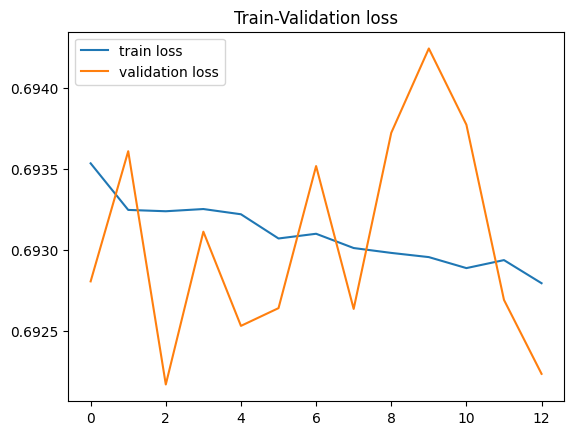

In [58]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [59]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5204081632653061, 'precision': 0.5204081632653061, 'f1': 0.5204081632653061, 'accuracy': 0.5204081632653061}
MALE {'recall': 0.265625, 'precision': 0.265625, 'f1': 0.265625, 'accuracy': 0.265625}
FEMALE {'recall': 0.765, 'precision': 0.765, 'f1': 0.765, 'accuracy': 0.765} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4772727272727273, 'precision': 0.4772727272727273, 'f1': 0.4772727272727273, 'accuracy': 0.4772727272727273}
MALE {'recall': 0.25060827250608275, 'precision': 0.25060827250608275, 'f1': 0.25060827250608275, 'accuracy': 0.25060827250608275}
FEMALE {'recall': 0.7217847769028871, 'precision': 0.7217847769028871, 'f1': 0.7217847769028871, 'accuracy': 0.7217847769028871} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}
MALE {'recall': 0.2904040404040404, 'precision': 0.29040

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933087681644055 	 Validation loss: 0.6933321174928697 	 
  1%|          | 574/57400 [00:05<07:42, 122.82it/s]
Epoch 2 	 Training loss: 0.6932904202140582 	 Validation loss: 0.6934155700570446 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:44, 121.16it/s]
Epoch 3 	 Training loss: 0.6932305400795222 	 Validation loss: 0.692944604461476 	 
  3%|▎         | 1722/57400 [00:15<07:36, 122.08it/s]
Epoch 4 	 Training loss: 0.6932109277630517 	 Validation loss: 0.693183067491499 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:25, 123.61it/s]
Epoch 5 	 Training loss: 0.6930936158534127 	 Validation loss: 0.6928242626836745 	 
  5%|▌         | 2870/57400 [00:25<07:27, 121.95it/s]
Epoch 6 	 Training loss: 0.6931587530345451 	 Validation loss: 0.6928240373983221 	 
  6%|▌         | 3444/57400 [00:30<07:22, 121.87it/s]
Epoch 7 	 Training loss: 0.6930916758987546 	 Validation loss: 0.6935016169386395 	 

1 epoch without improveme

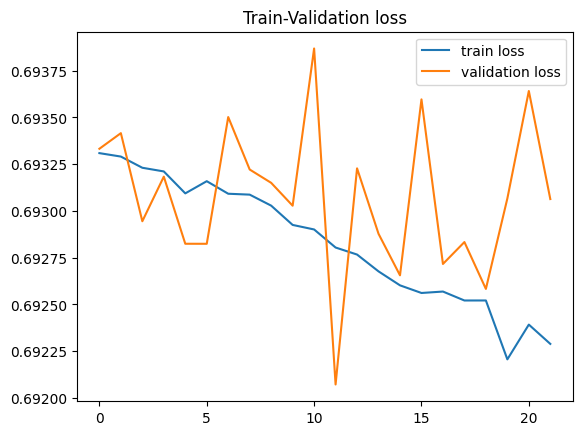

In [60]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [61]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.48596938775510207, 'precision': 0.48596938775510207, 'f1': 0.48596938775510207, 'accuracy': 0.48596938775510207}
MALE {'recall': 0.14583333333333334, 'precision': 0.14583333333333334, 'f1': 0.14583333333333334, 'accuracy': 0.14583333333333334}
FEMALE {'recall': 0.8125, 'precision': 0.8125, 'f1': 0.8125, 'accuracy': 0.8125} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4684343434343434, 'precision': 0.4684343434343434, 'f1': 0.4684343434343434, 'accuracy': 0.4684343434343434}
MALE {'recall': 0.15815085158150852, 'precision': 0.15815085158150852, 'f1': 0.15815085158150852, 'accuracy': 0.15815085158150852}
FEMALE {'recall': 0.8031496062992126, 'precision': 0.8031496062992126, 'f1': 0.8031496062992126, 'accuracy': 0.8031496062992126} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}
MALE

In [62]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49957482993197283, 'precision': 0.49957482993197283, 'f1': 0.49957482993197283, 'accuracy': 0.49957482993197283}
Métricas etiqueta male: {'recall': 0.1875, 'precision': 0.1875, 'f1': 0.1875, 'accuracy': 0.1875}
Métricas etiqueta female:  {'recall': 0.7991666666666667, 'precision': 0.7991666666666667, 'f1': 0.7991666666666667, 'accuracy': 0.7991666666666667}

 to
Resultado global: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
Métricas etiqueta male: {'recall': 0.18167072181670724, 'precision': 0.18167072181670724, 'f1': 0.18167072181670724, 'accuracy': 0.18167072181670724}
Métricas etiqueta female:  {'recall': 0.7987751531058618, 'precision': 0.7987751531058618, 'f1': 0.7987751531058618, 'accuracy': 0.7987751531058618}

 as
Resultado global: {'recall': 0.49674054758800523, 'precision': 0.49674054758800523, 'f1': 0.49674054758800523, 'accuracy': 0.49